<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](https://github.com/ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [7.1 Latin Hypercube and Quasi-Monte Carlo Sampling](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.01-Sampling-Based-Uncertainty-Quantification.html) | [Contents](toc.html) | [7.3 Meaningful Title Goes Here](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.03-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/07.02-Latin-Hypercube-sampling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.02-Latin-Hypercube-sampling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 7.2 Latin Hypercube Sampling


Created by V.Vijay Kumar Naidu (vvelagal@nd.edu)

The text, examples, and codes in this notebook were adapted from the following references:
* https://en.wikipedia.org/wiki/Latin_hypercube_sampling
*https://www.youtube.com/watch?v=r6rp-Qxc9xI
*https://pythonhosted.org/pyDOE/randomized.html)

* McClarren, Ryan G (2018). *Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 7 : Sampling-Based Uncertainty Quantification Monte Carlo and Beyond*, Springer, https://link.springer.com/chapter/10.1007%2F978-3-319-99525-0_7

In [ ]:
# Install Python libraries
!pip install -q sobol_seq
!pip install -q ghalton
!pip install -q pyDOE

In [ ]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
import math
from scipy.stats.distributions import norm
from scipy.stats import gamma
import sobol_seq
import ghalton
from scipy import stats
from pyDOE import *
%matplotlib inline

In [ ]:
# Download figures (if needed)
import os, requests, urllib

# GitHub pages url
url = "https://ndcbe.github.io/cbe67701-uncertainty-quantification/"

# relative file paths to download
# this is the only line of code you need to change
file_paths = ['figures/lhs_custom_distribution.png', 'figures/chapter7-screenshot.PNG']

# loop over all files to download
for file_path in file_paths:
    print("Checking for",file_path)
    # split each file_path into a folder and filename
    stem, filename = os.path.split(file_path)
    
    # check if the folder name is not empty
    if stem:
        # check if the folder exists
        if not os.path.exists(stem):
            print("\tCreating folder",stem)
            # if the folder does not exist, create it
            os.mkdir(stem)
    # if the file does not exist, create it by downloading from GitHub pages
    if not os.path.isfile(file_path):
        file_url = urllib.parse.urljoin(url,
                urllib.request.pathname2url(file_path))
        print("\tDownloading",file_url)
        with open(file_path, 'wb') as f:
            f.write(requests.get(file_url).content)
    else:
        print("\tFile found!")

Checking for figures/lhs_custom_distribution.png
	File found!
Checking for figures/chapter7-screenshot.PNG
	File found!


## 7.2.1 Latin Hypercube Basics

Latin hypercube sampling (LHS) is a statistical method for generating a near random  samples with equal intervals.

To generalize the Latin square to a hypercube, we define a X = (X1, . . . , Xp) as a collection of p independent random variables. To generate N samples, we divide the domain of each Xj in N intervals. In total there are Np such intervals. The intervals are defined by the N + 1 edges:


### 7.2.1.1 Latin Hypercube in 2D

Makes a Latin Hyper Cube sample and returns a matrix X of size n by 2. For each column of X, the  values of the column are randomly distributed such that each sample is located in  equally spaced intervals (0,1/n), (1/n,2/n), ..., (1-1/n,1) and their locations  are randomly permuted. The code is adapted from : https://www.youtube.com/watch?v=r6rp-Qxc9xI

In [ ]:
def latin_hypercube_2d_uniform(n):
    lower_limits=np.arange(0,n)/n
    upper_limits=np.arange(1,n+1)/n

    points=np.random.uniform(low=lower_limits,high=upper_limits,size=[2,n]).T
    np.random.shuffle(points[:,1])
    return points

<function matplotlib.pyplot.show(*args, **kw)>

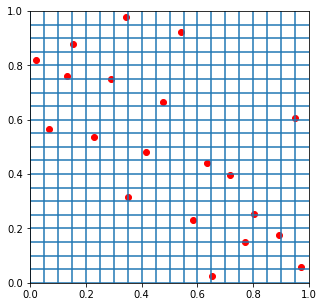

In [ ]:
n=20
p=latin_hypercube_2d_uniform(n)
plt.figure(figsize=[5,5])
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(p[:,0],p[:,1],c='r')

for i in np.arange(0,1,1/n):
    plt.axvline(i)
    plt.axhline(i)
plt.show

### 7.2.1.2 Latin-hypercube designs can be created using the following simple syntax** 

(Adapted from:https://pythonhosted.org/pyDOE/randomized.html)


In [ ]:
```
lhs(n, [samples, criterion, iterations])
```

**n**: an integer that tells us about the number of variables in a sample.

**samples**: an integer that tells us about the number of samples to be generated
criterion: a function that tells us how to generate the samples 

**“center” or “c”**: asks the lhs to generate  points such that they are  centered in the sampling interval

“maximin” or “m”: it asks the lhs to maximize the minimum distance between points and place the points in  randomized location in the interval

**“centermaximin” or “cm”**: it is same as maximin but the points are centered in the interval.

**“correlation” or “corr”**: minimize the maximum correlation coefficient

The output design will scale the variables from 0 to 1 which can be tranformed to distribution as per the user wish.

In [ ]:
from scipy.stats.distributions import norm
from pyDOE import *
lhd = lhs(2, samples=5)
lhd = norm(loc=0, scale=1).ppf(lhd)  # this applies to both factors here

Graphically, in each transformation the blue coloured points generated from lhs maps to the green sampled points that are normally distributed to generate values for each sample: (Adapted from https://pythonhosted.org/pyDOE/randomized.html)


An example for Latin-Hyper cube sampling

In [ ]:
design = lhs(4, samples=10)
from scipy.stats.distributions import norm
means = [1, 2, 3, 4]
stdvs = [0.1, 0.5, 1, 0.25]
for i in range(4):
    design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])

design

array([[1.01038798, 2.96384621, 1.66664945, 4.08995188],
       [0.98039537, 2.24799145, 3.68230066, 3.82708594],
       [1.28011085, 2.28301199, 2.44501943, 4.6418306 ],
       [0.91410412, 1.88397665, 2.71926383, 4.02262911],
       [0.91979907, 1.73539308, 2.95722586, 4.15159108],
       [0.96185965, 1.40469736, 3.04478481, 3.69932867],
       [0.87127105, 1.74656817, 3.36550728, 3.65675587],
       [1.04347425, 1.08778999, 2.13703733, 3.94872467],
       [1.1143877 , 2.58203348, 4.47359066, 3.8801158 ],
       [1.0641072 , 2.12054246, 4.13988503, 4.28057491]])

## 7.2.2 Advection-Diffusion-Reaction (ADR) Example

### 7.2.2.1 Set up diffusion reaction equation

The steady advection-diffusion-reaction(ADR) equation in one-spatial dimension with a spatially constant, but uncertain, diffusion coefficient, a linear reaction term, and a prescribed uncertain source.

$$
\nu \frac{du}{dx} - \omega \frac{d^2u}{dx^2} + \kappa(x)u = S(x)
$$
The QoI is total reaction rate:$$
Q= \int^{10}_{0} \kappa(x_ u)u(x)dx
$$
where v and ω are spatially constant with means
$$
\nu = 10, μ_{ω} = 20, 
$$
and
$$
Var(v) = 0.0723493, Var(ω) = 0.3195214.
$$

The reaction coefficient, κ(x), is  given by 
$$
κ(x) = κ_{l}  \space   x ∈ (5, 7.5)
$$ 
       $$  \space    κ_{h} \space otherwise$$ 
    
  The value of the source is given by
$$S(x) = qx(10 − x),$$ 

In [ ]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    #Solves the diffusion equation with Generalized Source
    A = sparse.dia_matrix((Nx,Nx),dtype="float")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A.tocsr(),Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

Solve diffusion equation

[10. 10. 10. ... 10. 10. 10.]
52.390252927703344


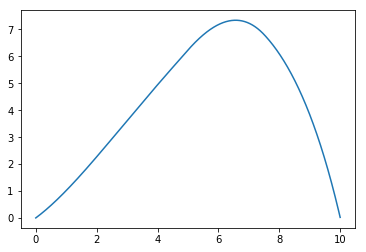

In [ ]:
Lx = 10
Nx = 2000
dx = Lx/Nx
Source_func = lambda x, q:  q*x*(10-x)
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>5)*(x<7.5)
v_func = lambda x,v: v*np.ones(x.size)
omega_func = lambda x,omega: omega*np.ones(x.size)

#nominal values

import csv

xs = np.linspace(dx/2,Lx-dx/2,Nx)
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)

omega_nom = 20
omega_var = 0.3195214
v_nom = 10
v_var = 0.0723493
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
vs = v_func(xs, v_nom)
print(vs)
sol,Q = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa)
print(Q)
plt.plot(xs,sol)
plt.show()

We are going to join gamma RVs with a normal copula. First we get the normal samples

In [ ]:
means = [v_nom, omega_nom, kappal_nom, kappah_nom, q_nom]
varmat = np.zeros((5,5))
#fill in diagonal
corrmat = np.ones((5,5))
corrmat[0,:] = (1,.1,-0.05,0,0)
corrmat[1,:] = (.1,1,-.4,.3,.5)
corrmat[2,:] = (-0.05,-.4,1,.2,0)
corrmat[3,:] = (0,.3,0.2,1,-.1)
corrmat[4,:] = (0,.5,0,-.1,1)
print(corrmat-corrmat.transpose())
print(corrmat)


varmat[np.diag_indices(5)] = [v_var, omega_var, kappal_var, kappah_var, q_var]
for i in range(5):
    for j in range(5):
        varmat[i,j] = math.sqrt(varmat[i,i])*math.sqrt(varmat[j,j])*corrmat[i,j]
print(varmat)
print(varmat-varmat.transpose())
print(np.linalg.eig(varmat))

# Warning: choosing a large number here will make the notebook take a long time
# to solve.
# samps = 10**6
samps = 10**4
# samps = 10**3
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))

print(np.max(test[:,0]))
import tabulate
#print(tabulate.tabulate(corrmat, tablefmt="latex", floatfmt=".2f"))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[ 1.    0.1  -0.05  0.    0.  ]
 [ 0.1   1.   -0.4   0.3   0.5 ]
 [-0.05 -0.4   1.    0.2   0.  ]
 [ 0.    0.3   0.2   1.   -0.1 ]
 [ 0.    0.5   0.   -0.1   1.  ]]
[[ 7.23493000e-02  1.52043249e-02 -3.92366580e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.52043249e-02  3.19521400e-01 -6.59651879e-04  8.93816670e-03
   7.51094687e-03]
 [-3.92366580e-05 -6.59651879e-04  8.51157000e-06  3.07547395e-05
   0.00000000e+00]
 [ 0.00000000e+00  8.93816670e-03  3.07547395e-05  2.77814200e-03
  -1.40072194e-04]
 [ 0.00000000e+00  7.51094687e-03  0.00000000e+00 -1.40072194e-04
   7.06235300e-04]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(array([3.20880078e-01, 7.14248146e-02, 2.58516363e-03, 4.68396801e-04,
       5.13602871e-06]), array([[-6.10221850e-02, -9.98104846e-01, -5.23689494e-03,
         5.95871096e-03,  2.80458596e-04],
       [-9.97466874e-01,  6

The distributions will be gammas

In [ ]:
def gen_samps(samps,test):
    #v will have v_nom = 10 v_var = 1 which makes alpha = 10 beta = 10 or theta = 1/10
    vsamps = gamma.ppf(test[:,0], a = 100, scale = 1/10)
    #print(np.mean(vsamps), np.var(vsamps), np.std(vsamps))
    #plt.hist(vsamps)

    #omega will have  omega_nom = 20, var = 4 which makes alpha = 100 beta = 5, theta = 1/5
    omegasamps = gamma.ppf(test[:,1], a = 100, scale = 1/5)
    #print(np.mean(omegasamps), np.var(omegasamps), np.std(omegasamps))
    #plt.hist(omegasamps)

    #kappa_l will have kappa_l = 0.1 var = (0.01)^2 this makes alpha = 100 and theta = 1/1000
    kappalsamps = gamma.ppf(test[:,2], a = 100, scale = 1/1000)
    #print(np.mean(kappalsamps), np.var(kappalsamps), np.std(kappalsamps))
    #plt.hist(kappalsamps)

    #kappa_h will have kappa_h = 2 var = .04 this makes alpha = 100 and theta = 1/50
    kappahsamps = (test[:,3]>0.005)*(1.98582-4.82135) + (4.82135) # #gamma.ppf(test[:,3], a = 100, scale = 1/50)
    print(np.mean(kappahsamps), np.var(kappahsamps), np.std(kappahsamps))
    #plt.hist(kappahsamps)

    #q will have q = 1 var = 0.01 this makes alpha = 100 and theta = 1/100
    qsamps = gamma.ppf(test[:,4], a = 100, scale = 1/100)
    #print(np.mean(qsamps), np.var(qsamps),np.std(qsamps))
    #plt.hist(qsamps)
    
    return vsamps,omegasamps,kappalsamps,kappahsamps,qsamps
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

var_list = [vsamps,omegasamps,kappalsamps,kappahsamps,qsamps]
cormat_emp = np.zeros((5,5))
tmp = np.vstack((var_list[0],var_list[1],var_list[2],var_list[3],var_list[4]))
cormat_emp = np.cov(tmp)
sens = np.array([-1.74063875491,-0.970393472244,13.1587256647,17.7516305655,52.3902556893])
print(cormat_emp, np.dot(sens,np.dot(cormat_emp,sens)))

2.0011318620000007 0.04318279093895298 0.20780469421779907
[[ 1.00876724e+00  1.75153708e-01 -4.80376658e-04 -1.49687366e-03
   2.78620413e-04]
 [ 1.75153708e-01  4.02281621e+00 -7.99696110e-03 -3.19230630e-02
   1.00074170e-01]
 [-4.80376658e-04 -7.99696110e-03  9.97417876e-05 -8.24879554e-05
   1.85805384e-06]
 [-1.49687366e-03 -3.19230630e-02 -8.24879554e-05  4.31871096e-02
   4.41484525e-04]
 [ 2.78620413e-04  1.00074170e-01  1.85805384e-06  4.41484525e-04
   1.00649099e-02]] 40.66575412647241


In [ ]:
Qs = np.zeros(samps)
print(np.mean(vsamps),np.mean(omegasamps),np.mean(kappalsamps), np.mean(kappahsamps),np.mean(qsamps))
for i in range(samps):
    sol,Qs[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))


9.996211170854629 19.991729539390022 0.10007439860826033 2.0011318620000007 1.0007749682671143


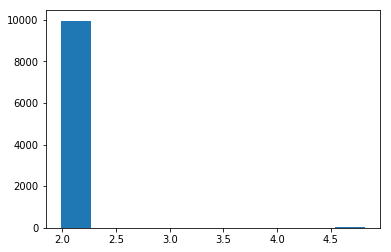

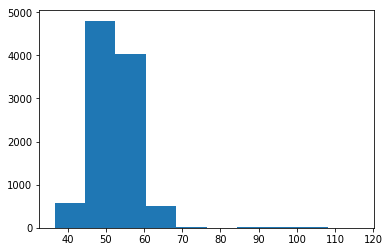

52.38429950498757 60.93083101449816 44.256769035451256 5.846536644275092 15.192880831520508 2.154994384485121


In [ ]:
plt.hist(kappahsamps)
plt.show()
plt.hist(Qs)
plt.show()
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))
Qref = Qs.copy()
np.savetxt(fname="ref_"+ str(samps) + "_binomial.csv", delimiter=",", X=Qref)

Now we will do 100 samples and compare

In [ ]:
samps = 100 #4*10**4
print (samps)
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

100
2.0141752999999993 0.07959828077091 0.2821316727538934


In [ ]:
QSRS = np.zeros(samps)
for i in range(samps):
    sol,QSRS[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))

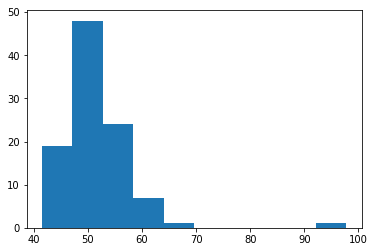

51.754085783529696 59.55016400777867 44.19214310775517 6.711582319278186 19.857958480592576 3.271194643345333


In [ ]:
plt.hist(QSRS)
plt.show()
print(np.mean(QSRS),stats.scoreatpercentile(QSRS,95),stats.scoreatpercentile(QSRS,5),np.std(QSRS), 
      stats.kurtosis(QSRS), stats.skew(QSRS))

### 7.2.2.2 Apply LHS

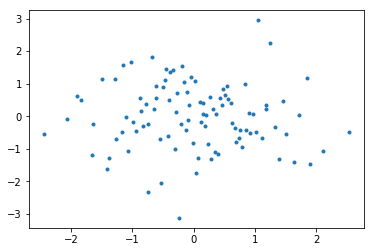

In [ ]:
#lhd will have the values in 0 to 1
lhd = lhs(5, samples=samps)
#now i need to turn these into samples from N(0,Corrmat)
#do cholesky fact
chol = np.linalg.cholesky(corrmat)

lhs_unif = np.zeros((samps,5))
for i in range(samps):
    lhs_unif[i,:] = np.dot(chol,norm.ppf(lhd[i,:]))
#print(lhs_unif)
#plt.plot(lhd[:,0],lhd[:,1],'.')
#plt.show()
plt.plot(lhs_unif[:,0],lhs_unif[:,1],'.')
plt.show()

In [ ]:
test_lhs = norm.cdf(lhs_unif)

vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)

1.9858199999999997 4.930380657631324e-32 2.220446049250313e-16


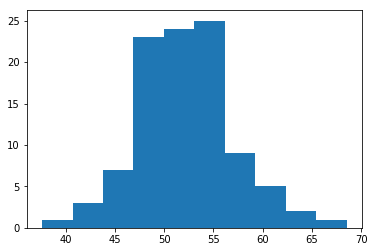

52.091501134877944 60.53399286590944 44.78023096114341 4.899665382873159 1.1994249416182612 0.18626015216253644
52.38429950498757 60.93083101449816 44.256769035451256 5.846536644275092 15.192880831520508 2.154994384485121


In [ ]:
QLHS = np.zeros(samps)
for i in range(samps):
    sol,QLHS[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))
plt.hist(QLHS)
plt.show()
print(np.mean(QLHS),stats.scoreatpercentile(QLHS,95),stats.scoreatpercentile(QLHS,5),np.std(QLHS), 
      stats.kurtosis(QLHS), stats.skew(QLHS))
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))

Below is Figure 7.13 in McClarren (2018); it shows the convergence rates of different methods compared against a LHS with 10$^6$ samples.

![alt text](https://)

<!--NAVIGATION-->
< [7.1 Latin Hypercube and Quasi-Monte Carlo Sampling](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.01-Sampling-Based-Uncertainty-Quantification.html) | [Contents](toc.html) | [7.3 Meaningful Title Goes Here](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.03-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/07.02-Latin-Hypercube-sampling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.02-Latin-Hypercube-sampling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>